In [35]:
import uproot
import awkward as ak
import numpy as np
from coffea import processor, util

%matplotlib inline
import matplotlib.pyplot as plt

from coffea.nanoaod import NanoEvents

from pyinstrument import Profiler
profiler = Profiler()
profiler.start()

from coffea.nanoaod import NanoEvents
from coffea.nanoaod.methods import FatJet, LorentzVector

arraycache = {}
events = NanoEvents.from_file(
    'data/nano_mc_2017_101.root',
    cache=arraycache,
    methods={
        'FatJetPFCands': LorentzVector,
    },
)
print(arraycache)

profiler.stop()

{}


In [2]:
good = (
        (events.Muon.counts >= 1)
        & (events.FatJet.counts >= 1)
        )

events = events[good]

goodMuon = (
    (events.Muon.pt > 27.)
    & (np.abs(events.Muon.eta) < 2.4)
    & (events.Muon.sip3d < 4)
    & (np.abs(events.Muon.dz) < 0.1)
    & (np.abs(events.Muon.dxy) < 0.05)
    & (events.Muon.mvaId == 2)
            )
nmuons = goodMuon.sum()

goodElectron = (
            (events.Electron.pt > 10)
            & (np.abs(events.Electron.eta) < 2.5)
            & (events.Electron.cutBased & (1 << 2)).astype(bool)  # 2017V2 loose                                                                                                    
        )
nelectrons = goodElectron.sum()

leptonsel = (nmuons == 1) & (nelectrons == 0) ## selection

met = events.MET

# select jet with muon closest
goodFatJet = (
    (events.FatJet.pt > 300.)
    & (np.abs(events.FatJet.eta) < 2.4)
    & (events.FatJet.msoftdrop > 10.)
    & (events.FatJet.jetId & 2)
            )
leadingmuon = events.Muon[goodMuon][:, 0:1]
ak8_muon_pair = leadingmuon.cross(events.FatJet)
ak8_muon_dR = ak8_muon_pair.i0.delta_r(ak8_muon_pair.i1)
leadingjet = events.FatJet[goodFatJet][ak8_muon_dR.argmin()]

# veto b-tag in opposite side
goodJet = (
    (events.Jet.pt > 30.)
    & (events.Jet.jetId & 2)
            )
jets = events.Jet[goodJet]
ak4_ak8_pair = jets.cross(leadingjet, nested=True)
ak4_ak8_dphi = ak4_ak8_pair.i0.delta_phi(ak4_ak8_pair.i1)
ak4_opposite = jets[(np.abs(ak4_ak8_dphi) > np.pi / 2).all()] ## selection

In [24]:
from uproot_methods import TLorentzVectorArray
leadingjet_p4 = TLorentzVectorArray.from_ptetaphim(leadingjet.pt, leadingjet.eta, leadingjet.phi, leadingjet.msoftdrop)
leadingmuon_p4 = TLorentzVectorArray.from_ptetaphim(leadingmuon.pt,leadingmuon.eta,leadingmuon.phi, leadingmuon.mass)

mm = (leadingjet_p4 - leadingmuon_p4).mass2
jmass = (mm>0)*np.sqrt(np.maximum(0, mm)) + (mm<0)*leadingjet.mass

#joffshell = leadingjet.msoftdrop < 125/2  # halfway point between offshell and onshell W
joffshell = jmass < 62.5
massassumption = 80.*joffshell + (125 - 80.)*~joffshell
print(massassumption)
print(leadingmuon.eta)
x = massassumption**2/(2*leadingmuon.pt*met.pt) + np.cos(leadingmuon.phi - met.phi)
met_eta = (
    (x < 1)*np.arcsinh(x*np.sinh(leadingmuon.eta))
    + (x > 1)*(
                leadingmuon.eta - np.sign(leadingmuon.eta)*np.arccosh(leadingmuon.eta)
                )
            )
met_p4 = TLorentzVectorArray.from_ptetaphim(met.pt, met_eta.fillna(0.), met.phi, np.zeros(met.size))

[[] [] [] ... [] [80.0] []]
[[] [] [] ... [] [0.27252197] []]


/Users/cristina/Library/Python/3.6/lib/python/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in arccosh
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [29]:
mm2 = (leadingjet - leadingmuon).mass2

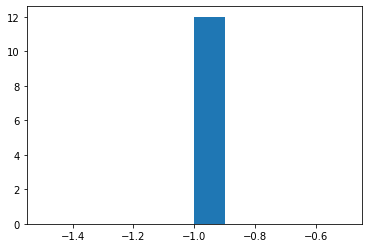

/Users/cristina/Library/Python/3.6/lib/python/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))


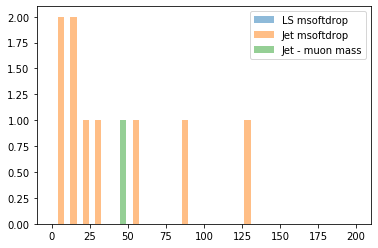

In [28]:
plt.hist(leadingjet.muonIdx3SJ.flatten());
plt.show()
plt.clf();
plt.hist(leadingjet.LSmsoftdrop.flatten(), bins=np.linspace(0, 200, 50), alpha=0.5, label='LS msoftdrop');
plt.hist(leadingjet.msoftdrop.flatten(), bins=np.linspace(0, 200, 50), alpha=0.5, label='Jet msoftdrop');
plt.hist((leadingjet - leadingmuon).mass.flatten(), bins=np.linspace(0, 200, 50), alpha=0.5, label='Jet - muon mass');
plt.gca().legend()

In [ ]:
lscut = (events.CustomAK8Puppi.muonIdx3SJ >= 0)
events = events[lscut.any()]
lscut = lscut[lscut.any()]
ljet = events.CustomAK8Puppi[:,0:1]
print(len(ljet.muonIdx3SJ.flatten()))
mu = events.Muon[ljet.muonIdx3SJ.flatten()]
print(len(mu),len(ljet))
print(mu-ljet)
from uproot_methods import TLorentzVectorArray

leadingjet_p4 = TLorentzVectorArray.from_ptetaphim(ljet.pt, ljet.eta, ljet.phi, ljet.msoftdrop)
leadingmuon_p4 = TLorentzVectorArray.from_ptetaphim(mu.pt,mu.eta,mu.phi, mu.mass)
print(leadingjet_p4.pad(1, clip=False).flatten())
print(leadingmuon_p4.pad(1, clip=False).flatten())
mm = (leadingjet_p4 - leadingmuon_p4).mass2

#mm = (ljet - mu).mass2
print(mm)
jmass = (mm>0)*np.sqrt(np.maximum(0, mm)) + (mm<0)*leadingjet.mass
print(len(jmass.flatten()))
print(len(mu.flatten()))
plt.hist2d(jmass.flatten(), mu.pt.flatten(), bins=50);

In [30]:
(met_p4 + leadingjet).mass

<JaggedArray [[] [] [] ... [] [173.1615789871054] []] at 0x000133b6c470>

In [ ]:
print(len(events.FatJet.muonIdx3SJ.flatten()))
print((events.FatJet.muonIdx3SJ.flatten()>=0).any())
lscut = (events.FatJet.muonIdx3SJ >= 0).any()
print(events.FatJet[(events.FatJet.muonIdx3SJ >= 0).any()].flatten())
print(events.FatJet.muonIdx3SJ.flatten())
newevents = events[lscut.any()]
lscut = lscut[lscut.any()]
jet = newevents.FatJet[lscut]
print((events.FatJet.muonIdx3SJ >= 0).any())
print(jet)

print(events.FatJet[:,0:1])
mu = events.Muon[events.FatJet[:,0:1].array.muonIdx3SJ]
mm = (leadingjet - mu).mass2

In [34]:
print(events.columns)

['LHEPart', 'MET', 'LHEReweightingWeight', 'OtherPV', 'SoftActivityJetHT2', 'genWeight', 'Generator', 'HLTriggerFinalPath', 'L1Reco', 'LHE', 'L1PreFiringWeight', 'LHEScaleWeight', 'SoftActivityJet', 'Pileup', 'HLT', 'Tau', 'SoftActivityJetHT', 'RawMET', 'fixedGridRhoFastjetCentralCalo', 'fixedGridRhoFastjetAll', 'TkMET', 'Jet', 'FatJet', 'GenDressedLepton', 'fixedGridRhoFastjetCentralChargedPileUp', 'HTXS', 'GenPart', 'luminosityBlock', 'SV', 'L1', 'Flag', 'CaloMET', 'Muon', 'GenMET', 'GenVisTau', 'LHEPdfWeight', 'event', 'SoftActivityJetHT10', 'fixedGridRhoFastjetCentralNeutral', 'L1simulation', 'LHEWeight', 'FsrPhoton', 'Photon', 'btagWeight', 'PSWeight', 'SubGenJetAK8', 'ChsMET', 'SoftActivityJetNjets2', 'SoftActivityJetNjets10', 'FatJetPFCands', 'Electron', 'run', 'CorrT1METJet', 'fixedGridRhoFastjetCentral', 'genTtbarId', 'TrigObj', 'SubJet', 'SoftActivityJetNjets5', 'GenJetAK8', 'GenJet', 'IsoTrack', 'PV', 'HLTriggerFirstPath', 'SoftActivityJetHT5', 'PuppiMET']
